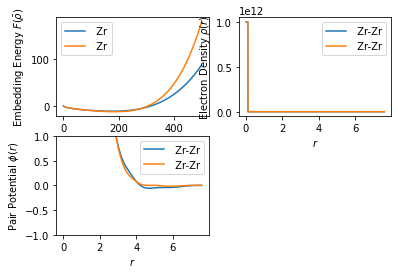

In [158]:
#sinusoid
from ase.build import bulk
from ase import Atoms
from ase.atom import Atom
from ase.calculators.emt import EMT
from ase.phonons import Phonons
from ase.dft.kpoints import *
import matplotlib.pyplot as plt
from ase.visualize import view
import numpy as np
from ase.calculators.eam import EAM
from ase.md import verlet
from ase.md.verlet import VelocityVerlet
from ase import units

zr1 = EAM(potential='Zr_3.eam.fs')
zr1.write_potential('Zr_3.eam.fs')
zr1.plot()

zr2 = EAM(potential='Zr_2.eam.fs')
zr2.write_potential('Zr_2.eam.fs')
zr2.plot()

LJ = LennardJones(sigma = 1, epsilon = 1, rc = 7.2 /1.5)

### Initialize MEAM HERE!!!!


In [62]:
def MC_2part(d,calc,steps = 600,stepsize = 1):
    a = Atoms([Atom('Zr', (0, 0, -d/2)), Atom('Zr', (0, 0, d/2))],calculator = calc)

    dyn = VelocityVerlet(a,timestep=stepsize*ase.units.fs)

    forces = []
    Etotal = []

    def forceplot(a):
        F = a.get_forces() 
        forces.append(F[0][2])
        etot = a.get_potential_energy() + a.get_kinetic_energy()
        Etotal.append(etot)


    for i in range(steps):
        dyn.run(1)
        forceplot(a)
    
    return forces, Etotal


def periodcheck(f):
    ps = []
    m1 = np.min(np.array(f))
    
    for i in  range(len(f)):
        if(f[i]-m1 < 0.3):
            ps.append(i)
            
    return ps

def periodiso(f,ps):
    for i in range(len(ps)-1):
        if((ps[i+1] - ps[i]) > 20):
            return f[ps[i]:ps[i+1]]
        
    return f



In [63]:
def HAM_check_2d(d,calc,steps = 600,stepsize = 1):
    
    forces,energy = MC_2part(d,calc,steps = 600,stepsize = 1)
    ps = periodcheck(forces)
    f = periodiso(forces,ps)
    
    dft = np.abs(np.fft.rfft(f))
    ndft = np.abs(dft)/np.trapz(np.abs(dft))
    
    Ham = np.std(ndft)**2
    
    return forces,f,dft,ndft,Ham

In [71]:
hamarray = []



0.0013332126186889513


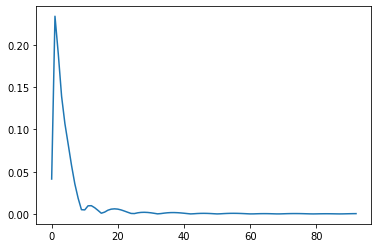

In [100]:



atoms = bulk('Zr', 'hcp', a=3.6, c = 5.20) * (3, 3, 3)

j = np.array(atoms.get_positions())
#print(j)



In [160]:
def advance(atoms,calc,idx,vel,dt):
    #initialize
    atoms.calc = calc
    mass = np.array(atoms.get_masses())
    m = mass[3]
    force = np.array(atoms.get_forces())
    pos = np.array(atoms.get_positions())
    
    #move1
    accel = force[idx] / m
    vel_half = vel + 0.5*dt*accel
    pos_new = pos 
    pos_new[idx]+= dt*vel_half
    
    atoms.set_positions(pos_new)
    
    #move2
    force2 = np.array(atoms.get_forces())
    accel2 = force2[idx] / m
    vel_new = vel_half + 0.5*dt*accel2
    
    return force2[idx],vel_new,pos_new[idx]

def changearray_hcp(mode,dist,atom):
    c = np.zeros(shape = (54,3))
    c[atom] = (mode)*dist
    return c

def GridMC_hcp_1(calc,steps,mode,dist,atom):
    dt = 0.1
    
    atoms = bulk('Zr', 'hcp', a=3.24, c = 5.22) * (3, 3, 3)
    j = np.array(atoms.get_positions())
    cinit = changearray_hcp(mode,dist,atom)
    pos1 = j + cinit
    atoms.set_positions(pos1)
    
    vel = [0,0,0]
    
    forcearray = []
    posarray = []
    
    for i in range(steps):
        f,vel,pos = advance(atoms,calc,atom,vel,dt)
        forcearray.append(f)
        posarray.append(pos)
        if(i%20 ==0):
            print(i)
        
    return forcearray,posarray


def GridMC_bcc_1(calc,steps,mode,dist,atom):
    dt = 0.1
    
    atoms = bulk('Zr', 'bcc', a=3.6) * (3, 3, 3)
    j = np.array(atoms.get_positions())
    cinit = changearray_hcp(mode,dist,atom)
    pos1 = j + cinit
    atoms.set_positions(pos1)
    
    vel = [0,0,0]
    
    forcearray = []
    posarray = []
    
    for i in range(steps):
        f,vel,pos = advance(atoms,calc,atom,vel,dt)
        forcearray.append(f)
        posarray.append(pos)
        if(i%20 ==0):
            print(i)
        
    return forcearray,posarray
        

    
def HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=zr2):
    
    forc,posi = GridMC_hcp_1(calc,steps,mode,displacement,atom)
    farray = np.array(forc)
    forces = np.sqrt(farray[:,0]**2 + farray[:,1]**2+farray[:,2]**2)
    
    ps = periodcheck(forces)
    f = periodiso(forces,ps)
    
    dft = np.abs(np.fft.rfft(f))
    ndft = np.abs(dft)/np.trapz(np.abs(dft))
    
    Ham = np.std(ndft)**2
    
    return forces,f,dft,ndft,Ham
    
    
    
def HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=zr2):
    
    forc,posi = GridMC_bcc_1(calc,steps,mode,displacement,atom)
    farray = np.array(forc)
    forces = np.sqrt(farray[:,0]**2 + farray[:,1]**2+farray[:,2]**2)
    
    ps = periodcheck(forces)
    f = periodiso(forces,ps)
    
    dft = np.abs(np.fft.rfft(f))
    ndft = np.abs(dft)/np.trapz(np.abs(dft))
    
    Ham = np.std(ndft)**2
    
    return forces,f,dft,ndft,Ham
    

In [132]:
f,p = GridMC_hcp_1(zr2,600,[1,1,0],1,14)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580


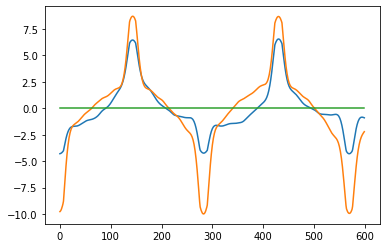

In [151]:
plt.plot(f)
forces = np.array(f)



#plt.plot(np.sqrt(np.sum(forces[2:]*forces[2:], axis = 0)))

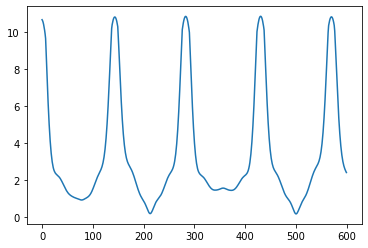

In [161]:
forces,f,dft,ndft,Ham = HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=LJ)
forces,f,dft,ndft,Ham = HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces,f,dft,ndft,Ham = HAM_check_multi_hcp(displacement=0.5,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces,f,dft,ndft,Ham = HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=meam)

forces,f,dft,ndft,Ham = HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=LJ)
forces,f,dft,ndft,Ham = HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces,f,dft,ndft,Ham = HAM_check_multi_bcc(displacement=0.5,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces,f,dft,ndft,Ham = HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=meam)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580


0.019741620327551553


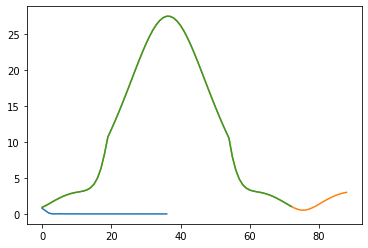

In [168]:
plt.plot(ndft)
plt.plot(forces[201:290])
plt.plot(f)
print(Ham)

In [169]:
forces1,f1,dft1,ndft1,Ham1 = HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=LJ)
forces2,f2,dft2,ndft2,Ham2 = HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces3,f3,dft3,ndft3,Ham3 = HAM_check_multi_hcp(displacement=0.5,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces4,f4,dft4,ndft4,Ham4 = HAM_check_multi_hcp(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=meam)

forces5,f5,dft5,ndft5,Ham5 = HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=LJ)
forces6,f6,dft6,ndft6,Ham6 = HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces7,f7,dft7,ndft7,Ham7 = HAM_check_multi_bcc(displacement=0.5,mode=[1,1,0],atom=14,steps=600,calc=zr2)
forces8,f8,df8t,ndft8,Ham8 = HAM_check_multi_bcc(displacement=1,mode=[1,1,0],atom=14,steps=600,calc=meam)

NameError: name 'LJ' is not defined

In [ ]:
plt.plot(forces1,label="hcp LJ")
plt.plot(forces2,label="hcp EAM")
plt.plot(forces3,label="hcp MEAM")
plt.plot(forces4,label="hcp EAM short")
plt.legend()
plt.xlabel("time")
plt.ylabel("force magnitude")

In [ ]:
plt.plot(f1,label="hcp LJ")
plt.plot(f2,label="hcp EAM")
plt.plot(f3,label="hcp MEAM")
plt.plot(f4,label="hcp EAM short")
plt.legend()
plt.xlabel("time")
plt.ylabel("force magnitude")

In [ ]:
plt.plot(ndft1,label="hcp LJ")
plt.plot(ndft2,label="hcp EAM")
plt.plot(ndft3,label="hcp MEAM")
plt.plot(ndft4,label="hcp EAM short")
plt.legend()
plt.xlabel("time")
plt.ylabel("force magnitude")

In [ ]:
plt.plot(forces5,label="bcc LJ")
plt.plot(forces6,label="bcc EAM")
plt.plot(forces7,label="bcc MEAM")
plt.plot(forces8,label="bcc EAM short")
plt.legend()
plt.xlabel("time")
plt.ylabel("force magnitude")

In [ ]:
plt.plot(f5,label="bcc LJ")
plt.plot(f6,label="bcc EAM")
plt.plot(f7,label="bcc MEAM")
plt.plot(f8,label="bcc EAM short")
plt.legend()
plt.xlabel("time")
plt.ylabel("force magnitude")

In [ ]:
plt.plot(ndft5,label="bcc LJ")
plt.plot(ndft6,label="bcc EAM")
plt.plot(ndft7,label="bcc MEAM")
plt.plot(ndft8,label="bcc EAM short")
plt.legend()
plt.xlabel("time")
plt.ylabel("force magnitude")

In [ ]:
print(Ham1)
print(Ham2)
print(Ham3)
print(Ham4)
print(Ham5)
print(Ham6)
print(Ham7)
print(Ham8)